# MNISTデータの読み込み

In [23]:
import numpy as np
import tensorflow as tf
from keras.datasets import mnist # MNISTデータセットのインポート
from keras.utils import to_categorical

#--------------------------------------------------------------
# データセットのロード
# X：画像データ（28x28ピクセルの行列）、Y：正解ラベル（0～9の数値）
# train：モデルの学習用、test：学習に使わない評価・検証用
#--------------------------------------------------------------
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# 変換後の形状を確認（例: 学習用なら (60000, 28, 28)）
print(X_train.shape)

# パラメータの設定
image_cols = 784  # 1データの要素数（28×28ピクセル = 784）
out_size = 10     # 分類するクラス数（数字の0～9に対応）

#--------------------
# 入力データの前処理
#--------------------
# 28x28の2次元画像を784要素の1次元配列（行ベクトル）に変換し、
# 0~255の輝度値を0~1の範囲に正規化（スケーリング）する
x_train = X_train.reshape(-1, image_cols) / 255
x_test = X_test.reshape(-1, image_cols) / 255

# 変換後の形状を確認（例: 学習用なら (60000, 784)）
print(x_train.shape)

#-------------------
# 出力データの前処理
#-------------------
y_train = to_categorical(Y_train, out_size)  # 学習用ラベルをone-hot表現へ変換
y_test = to_categorical(Y_test, out_size)    # 検証用ラベルをone-hot表現へ変換

(60000, 28, 28)
(60000, 784)


# 活性化関数、損失関数の定義

In [24]:
#import numpy as np
import matplotlib.pyplot as plt

#---------------
# シグモイド関数
#---------------
class Sigmoid:
    def func_out(self, x):   # 関数の定義
        out = 1 / (1 + np.exp(-x))
        return out
    def func_diff(self, x):  # 関数の微分形
        out = 1 / (1 + np.exp(-x))
        return out*(1-out)

#----------
# 損失関数
#----------
class SSE:  # 二乗和誤差 (Sum of Squared Error)
    def loss_out(self, x, t):
        E = np.sum((x-t)**2)/2  # バッチ全体の損失の合計
        return E
    def loss_diff(self, x, t):
        return x-t


#-----------------------------------------------------------------------------
# 演習用にRelu関数のクラス追加

#---------
#ReLu関数
#---------
class Relu:
    def __init__(self):
        self.mask = None
    def func_out(self, x):   #関数の定義
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def func_diff(self, x):  #関数の微分形
        result = np.ones((x.shape[0], x.shape[1]))
        result[self.mask] = 0
        return result

# 隠れ層、出力層のクラス定義

In [25]:
class InnerLayer:
    #----------------------
    # インスタンスの初期化
    #----------------------
    def __init__(self, W_row, W_column, batch_size):
        # self.W = 0.05*np.random.randn(W_row, W_column)  # 重みの初期化（標準正規分布 * 0.05)
        self.W = 0.05*np.random.randn(W_row, W_column+1)  # 重みの初期化（標準正規分布 * 0.05） #--- バイアスを含めた場合の重み ---#
        # self.dw = np.zeros((W_row, W_column))
        self.dw = np.zeros((W_row, W_column+1))                                                 #--- バイアスを含めた場合の重みの勾配 ---#
        self.A = np.zeros((W_row,batch_size))
        # self.z_in = np.zeros((W_column,batch_size))
        self.z_in = np.zeros((W_column+1,batch_size))                                           #--- バイアスを含めた場合の入力保持値 ---#
        self.z_out = np.zeros((W_row,batch_size))
        self.DG_out = np.zeros((W_row,batch_size))
        self.Activate = Relu()  #活性化関数

    #--------
    # 順伝播
    #--------
    def forward(self, x):
        x = np.append(x, np.ones((1,x.shape[1])), axis=0)                                       #--- バイアスを含めた場合の入力値の変更 ---#
        self.z_in = x               # 入力値を保存（逆伝播で使用）
        self.A = np.dot(self.W, x)  # 重み付き和の計算
        self.z_out = self.Activate.func_out(self.A)  # 活性化関数の適用
        return self.z_out

    #--------
    # 逆伝播
    #--------
    def backward(self, DG_in):
        DG_tmp = DG_in * self.Activate.func_diff(self.A)  # 入力誤差に活性化関数の微分を掛ける
        self.dw = np.dot(DG_tmp, self.z_in.T)             # 重みの勾配を計算
        W_copy = np.copy(self.W)                                                                #--- バイアスを含めた場合の入力値の変更 ---#
        W_copy = np.delete(W_copy, -1, axis=1)                                                  #--- バイアスを含めた場合の入力値の変更 ---#
        self.DG_out = np.dot(W_copy.T,DG_tmp)                                                   #--- バイアスを含めた場合の入力値の変更 ---#
        # self.DG_out = np.dot(self.W.T,DG_tmp)             # 前の層へ渡す勾配を計算
        return self.DG_out

    #------------------------------------------------------------
    # 予測値出力（forwardと違い、内部パラメータの更新は行わない）
    #------------------------------------------------------------
    def predict(self, x):
        x = np.append(x, np.ones((1,x.shape[1])), axis=0)                                       #--- バイアスを含めた場合の入力値の変更 ---#
        A = np.dot(self.W, x)              # 重み付き和の計算
        z_out = self.Activate.func_out(A)  # 活性化関数の適用
        return z_out

#---------------------------------
# InnerLayerを継承して出力層を作る
# *** Layerと全く同じであるが、          ***
# *** 出力層にはsoftmax関数を使って      ***
# *** 出力を確率として出すこともあるため ***
# *** あえて別名でインスタンスを作成する ***
#---------------------------------
class OutLayer(InnerLayer):
    def __init__(self, W_row, W_column, batch_size):
        # self.W = 0.05*np.random.randn(W_row, W_column)  # 重みの初期化（標準正規分布 * 0.05）
        # self.dw = np.zeros((W_row, W_column))
        # self.A = np.zeros((W_row,batch_size))
        # self.z_in = np.zeros((W_column,batch_size))
        # self.z_out = np.zeros((W_row,batch_size))
        # self.DG_out = np.zeros((W_row,batch_size))
        # self.Activate = Sigmoid()  #活性化関数

        #----------------------------#
        #--- バイアスを含めた場合 ---#
        #----------------------------#
        self.W = 0.05*np.random.randn(W_row, W_column+1)  # 重みの初期化（標準正規分布 * 0.05） #--- バイアスを含めた場合の重み ---#
        self.dw = np.zeros((W_row, W_column+1))                                                 #--- バイアスを含めた場合の重みの勾配 ---#
        self.A = np.zeros((W_row,batch_size))
        self.z_in = np.zeros((W_column+1,batch_size))                                           #--- バイアスを含めた場合の入力保持値 ---#
        self.z_out = np.zeros((W_row,batch_size))
        self.DG_out = np.zeros((W_row,batch_size))
        self.Activate = Relu()  #活性化関数



# ニューラルネットワークのクラス定義
#### 入力層→隠れ層1→隠れ層2→出力層

In [26]:
class NeuralNetwork:
    #------------------
    # インスタンスの初期化
    #------------------
    def __init__(self, input_size, hidden_size, out_size, lr, batch_size):
        self.Layer1 = InnerLayer(hidden_size, input_size, batch_size)
        self.Layer2 = InnerLayer(hidden_size, hidden_size, batch_size)
        self.LastLayer = OutLayer(out_size, hidden_size, batch_size)
        self.output = np.zeros((out_size, batch_size))
        self.Loss = SSE()  # 損失関数
        self.eta = lr      # 学習係数
        self.E = 0         #損失

    #--------
    # 順伝播
    #--------
    def FORWARD(self, x):
        layer1_out = self.Layer1.forward(x)               # 入力層→隠れ層1
        layer2_out = self.Layer2.forward(layer1_out)      # 隠れ層1→隠れ層2
        self.output = self.LastLayer.forward(layer2_out)  # 隠れ層2→出力層

    #--------
    # 逆伝播
    #--------
    def BACKWARD(self, t):
        self.E = self.Loss.loss_out(self.output, t)/batch_size  # 損失値の計算
        DG = self.Loss.loss_diff(self.output,t)
        DG_lastlayer = self.LastLayer.backward(DG)      # 損失→出力層
        DG_layer2 = self.Layer2.backward(DG_lastlayer)  # 出力層→隠れ層2
        self.Layer1.backward(DG_layer2)                 # 隠れ層2→隠れ層1

    #-----------
    # 予測値出力
    #-----------
    def PREDICT(self, x):
        layer1_out = self.Layer1.predict(x)
        layer2_out = self.Layer2.predict(layer1_out)
        return self.LastLayer.predict(layer2_out)

    #-----------
    # 重みの更新
    #-----------
    def WeightUpdata(self):
        self.Layer1.W -= self.eta*self.Layer1.dw
        self.Layer2.W -= self.eta*self.Layer2.dw
        self.LastLayer.W -= self.eta*self.LastLayer.dw


# MNISTの手書き文字識別に使うモデルのクラス定義

In [27]:
class MNIST_MODEL:
    #------------------
    # インスタンスの初期化
    #------------------
    def __init__(self, input_size, hidden_size, out_size, lr, batch_size):
        self.NN = NeuralNetwork(input_size, hidden_size, out_size, lr, batch_size)

    #------
    # 学習
    #------
    def Train(self, x_data, t_data):
        self.NN.FORWARD(x_data)   # 順伝播
        self.NN.BACKWARD(t_data)  # 逆伝播
        self.NN.WeightUpdata()    # 重み更新

    #------
    # 予測
    #------
    def Predict(self, x):
        return self.NN.PREDICT(x)

    #-----------
    # 損失を返す
    #-----------
    def Get_Loss(self):
        return self.NN.E

    #-----------
    # 精度を返す
    #-----------
    def Get_Accuracy(self, x, t):
        p = self.NN.PREDICT(x)
        p = np.argmax(p, axis=0)  # 列方向に最大の値を持つ要素番号を返す(予測)
        t = np.argmax(t, axis=0)  # 列方向に最大の値を持つ要素番号を返す(正解)
        accuracy = np.sum(p == t) / x.shape[1]  # 予測と正解が一致する個数をデータ数で割る
        return accuracy

# 学習の実施、検証用データを用いた評価

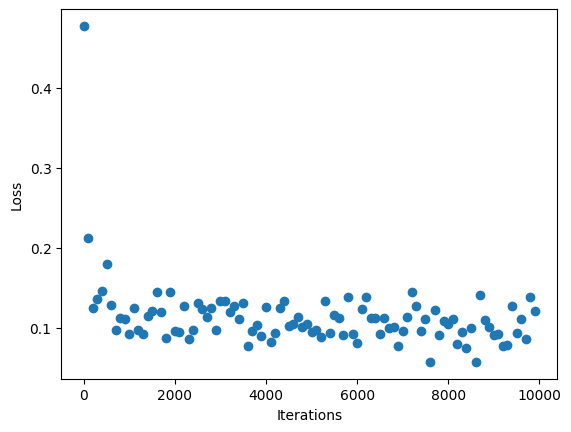

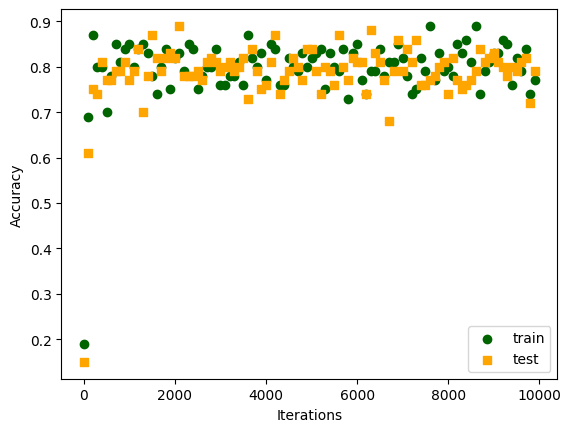

Accuracy =  79.78 %


In [32]:
train_size = x_train.shape[0] # 学習データの総数 (60000)
test_size = x_test.shape[0]   # テストデータの総数 (10000)
input_size = x_train.shape[1] # 入力層のサイズ (784)
out_size = y_train.shape[1]   # 出力層のサイズ (10)
batch_size = 100              # ミニバッチのサイズ
hidden_size = 50              # 隠れ層のニューロン数
lr = 0.01                     # 学習係数 (Learning Rate)

# モデルのインスタンス化
MM = MNIST_MODEL(input_size, hidden_size, out_size, lr, batch_size)

# --- 学習の実行 ---
iters_num = 10000      # 繰り返しの回数
iters_list = []        # グラフ用：繰り返し回数の記録
Loss_list = []         # グラフ用：損失の記録
acc_list_train = []    # グラフ用：学習データの精度記録
acc_list_test = []     # グラフ用：テストデータの精度記録

#--------------
# モデルの学習
#--------------
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)  # ミニバッチの作成（ランダムにデータを抽出）
    x_batch = x_train[batch_mask].T   # 列ベクトルにするための転置
    y_batch = y_train[batch_mask].T   # 列ベクトルにするための転置
    test_batch_mask = np.random.choice(test_size, batch_size)  # テストデータも同様にミニバッチの作成（ランダムにデータを抽出）
    x_test_batch = x_test[test_batch_mask].T  # 列ベクトルにするための転置
    y_test_batch = y_test[test_batch_mask].T  # 列ベクトルにするための転置

    # 学習の実施（順伝播・逆伝播・重み更新を一括実行）
    MM.Train(x_batch, y_batch)

    # batch_sizeごとに進捗の記録
    if i % batch_size == 0:
        iters_list.append(i)
        Loss_list.append(MM.Get_Loss())
        acc_list_train.append(MM.Get_Accuracy(x_batch, y_batch))
        acc_list_test.append(MM.Get_Accuracy(x_test_batch, y_test_batch))

#--------------
# 結果の可視化
#--------------
# 損失の推移をプロット
plt.scatter(iters_list, Loss_list)
plt.xlabel("Iterations")  # 横軸：繰り返し回数
plt.ylabel("Loss")        # 縦軸：損失
plt.show()

# 精度の推移をプロット
plt.scatter(iters_list, acc_list_train, c='darkgreen', marker='o', label='train')
plt.scatter(iters_list, acc_list_test, c='orange', marker='s', label='test')
plt.xlabel("Iterations")  # 横軸：繰り返し回数
plt.ylabel("Accuracy")    # 縦軸：精度
plt.legend()
plt.show()

#----------
# 最終評価
#----------
acc_cnt = 0
test_num = test_size

# 全てのテストデータに対して1件ずつ推論を行い、正解数をカウント
error_index = []                               # 予測失敗したデータを記録
for i_test in range(test_num):
    x_test_new = x_test[i_test].reshape(-1,1)  # 1件のデータを列ベクトル化
    y_test_new = y_test[i_test].reshape(-1,1)
    answer = np.argmax(y_test[i_test])         # 正解の数値
    result = np.argmax(MM.Predict(x_test_new)) # モデルの予測数値
    if answer == result:
      acc_cnt += 1
    else:
      error_index.append(i_test)
print("Accuracy = ", acc_cnt/test_num * 100, "%")  # 最終的な正解率を表示

In [ ]:
#------------------------------
#--- 予測失敗した画像の表示 ---
#------------------------------

#print(error_index)   #失敗したインデックスの一覧を表示

idx_pos = np.random.choice(len(error_index))  # 0~(リストの個数)でランダムな数を取得
error_idx = error_index[idx_pos]              # ランダムに一つのインデックスを取得

# 画像の描画
plt.imshow(X_test[error_idx], cmap='gray')           # 予測失敗したデータを白黒（gray）で表示
plt.title(f"Label: {np.argmax(y_train[error_idx])}") # 正解ラベルを表示
plt.axis('off') # 目盛りを非表示にする
plt.show()